In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Correlation approach to clense data
Use pairwise correlation in order to decide which which markets are duplicates then use the one with the longer history. 

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

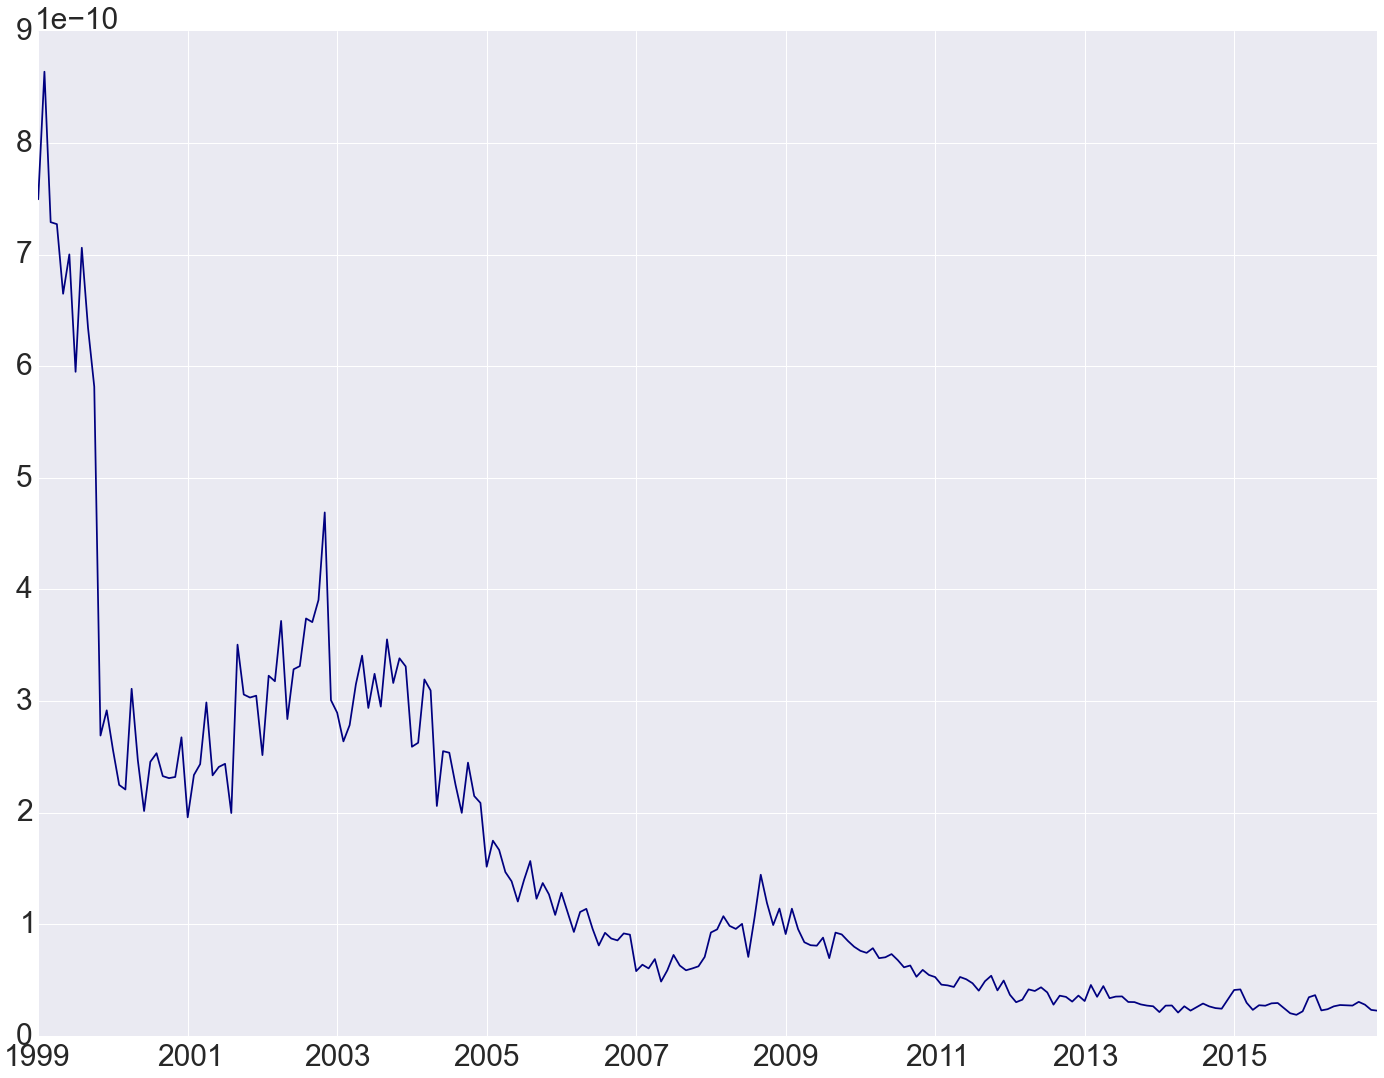

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

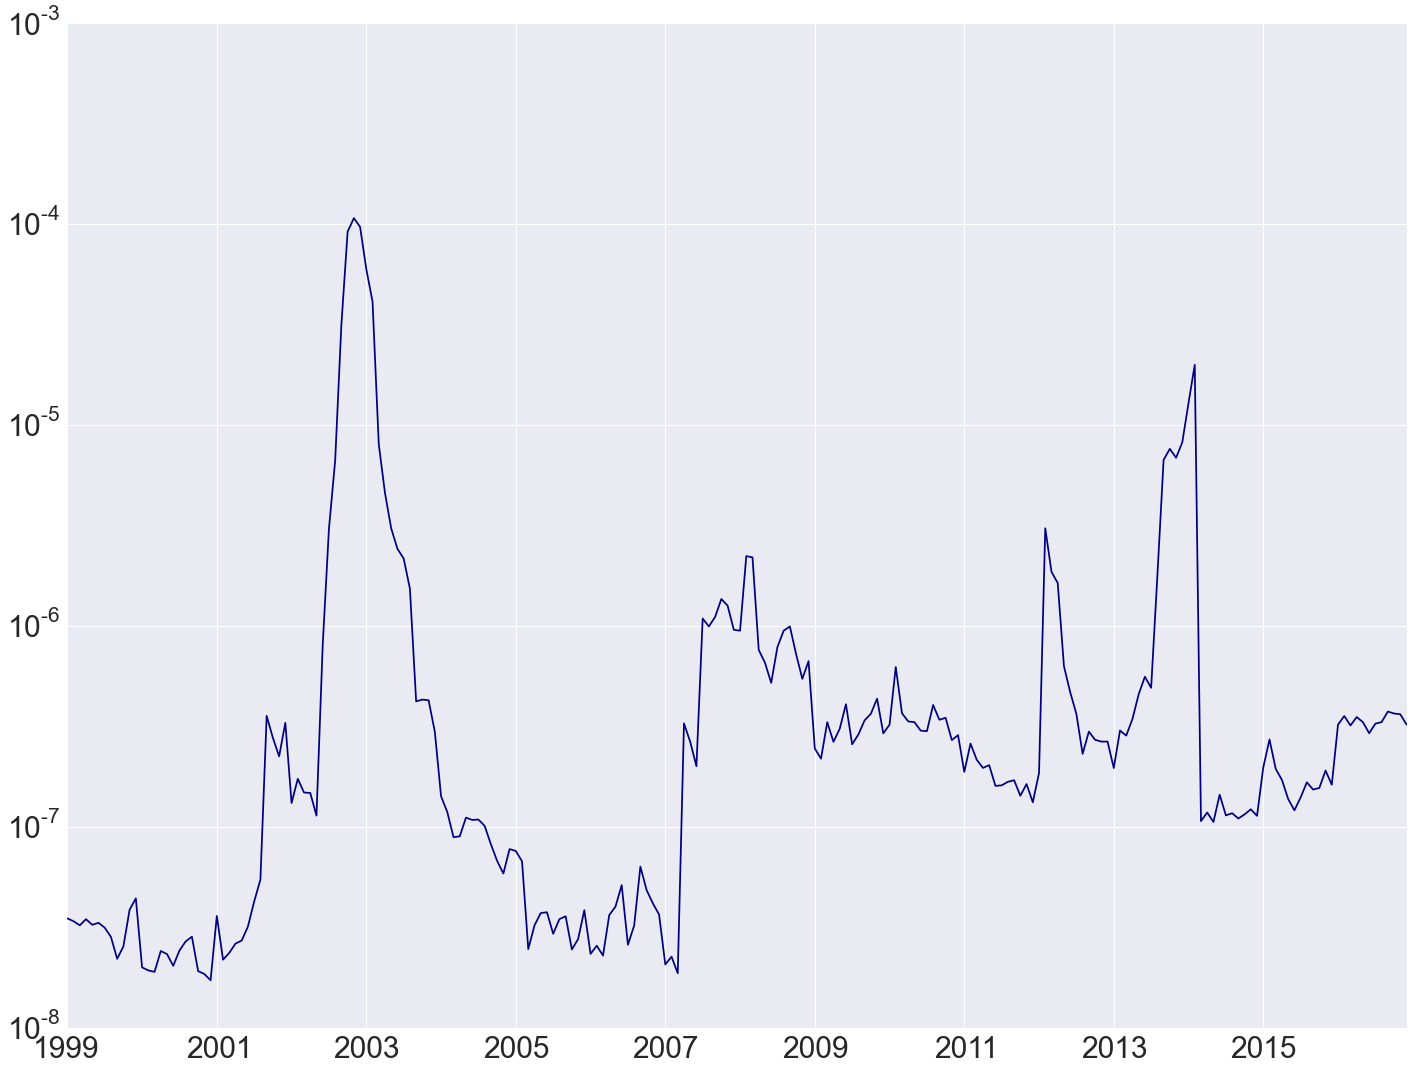

In [6]:
amihud.std(axis=1).dropna().plot(logy=True,colormap='jet')

In [14]:
factors=pd.read_csv('market_liquidity_factors.csv',index_col=0,parse_dates=[0])

In [21]:
factors['Amihud']=np.log(amihud.median(axis=1).dropna())

In [22]:
factors.dropna()

,Amihud,LIBOR,FedFunds,TED,FinancialStress,NBER_Recessions
2001-01-31,-22.354122,6.03875,5.98,0.56,0.880,0.0
2001-02-28,-22.177041,5.62625,5.49,0.32,0.849,0.0
2001-03-31,-22.136158,5.66813,5.31,0.68,0.981,0.0
2001-04-30,-21.931525,4.76875,4.80,0.48,0.976,1.0
2001-05-31,-22.178318,4.22875,4.21,0.44,0.759,1.0
2001-06-30,-22.146549,4.24000,3.97,0.27,0.617,1.0
2001-07-31,-22.134953,3.96625,3.77,0.21,0.593,1.0
2001-08-31,-22.334707,3.74250,3.65,0.16,0.501,1.0
2001-09-30,-21.771655,3.56531,3.07,0.24,0.954,1.0
2001-10-31,-21.908032,2.70500,2.49,0.19,0.715,1.0


I need to understand what the VAR should look like.  Previously I used something that looked like this:

$$ X_t = \mu + \Phi X_{t-1} - \Sigma \varepsilon_t $$

But what is X in this case?

In [23]:
res = VAR.VAR(endog=factors.dropna()).fit()
print res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 04, Jul, 2017
Time:                     14:34:36
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -20.0900
Nobs:                     190.000    HQIC:                  -20.5170
Log likelihood:           401.146    FPE:                9.19169e-10
AIC:                     -20.8078    Det(Omega_mle):     7.39809e-10
--------------------------------------------------------------------
Results for equation Amihud
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -1.216134         0.578418           -2.103           0.037
L1.Amihud                  0.947099         0.025575           37.033           0.000
L1.LIBOR                  -0.004713    